In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk import bigrams
import networkx as nx
from textblob import TextBlob

pd.set_option("display.float_format", lambda x: "%.5f" % x)
pd.set_option("display.max_columns", 20)
pd.set_option("display.min_rows", 50)
pd.set_option("display.max_rows", 50)

In [2]:
def clean_str(df, col='full_text', split=True):
    """
    Remove punctuation and url's from a full text Tweet.
    Takes de df[col='full_text'] and returns it lowecased, with out puntuation and splitted 
    if split=True
    
    df
    col='full_text'
    split=True
    """
    punc_url = df[col].str.replace("([^0-9A-Za-z \t])|(\w+:\/\/\S+)",'')
    punc_url = punc_url.str.lower()
    if split:
        punc_url = punc_url.str.split()
        return punc_url
    else:
        return punc_url
    

In [3]:
def flatten_list(list_to_flatten):
    """returns a flaten list from a given 2 lvl list"""
    return [item for sublist in list_to_flatten for item in sublist]

In [4]:
def count_common(words, x=20):
    """given a clean, flaten word list returns a list with the x most common words."""
    count = Counter(words)
    return count.most_common(x)

In [5]:
def plot_count(count, title):
    """creates a df of a word count & returns it."""
    common_words = pd.DataFrame(count,
                             columns=['words', 'count'])

    fig, ax = plt.subplots(figsize=(8, 8))
    # Plot horizontal bar graph
    common_words.sort_values(by='count').plot.barh(x='words',
                          y='count',
                          ax=ax,
                          color="purple")
    ax.set_title(title)
    plt.show()
    return common_words

In [6]:
def remove_stop_words(word_list, lang='english'):
    """ from a given two level word list, removes the selected language stop words.returns a two lvl list"""
    stop_words = set(stopwords.words(lang))
    un_worded = []
    for sub in word_list:
        t_words = []
        for word in sub:
            if word not in stop_words:
                t_words.append(word)
        un_worded.append(t_words)
    return un_worded

In [7]:
def remove_words(word_list, *arg, lang='english'):
    """ 
    from a given two level word list, removes the selected language stop words or the 
    word list proportonated.
    returns a two lvl list.
    """
    
    un_worded = []
    if arg:
        for sub in word_list:
            t_words = []
            for word in sub:
                if word not in arg:
                    t_words.append(word)
            un_worded.append(t_words)
    else:
        stop_words = set(stopwords.words(lang))
        for sub in word_list:
            t_words = []
            for word in sub:
                if word not in stop_words:
                    t_words.append(word)
            un_worded.append(t_words)
    return un_worded

### Load data

In [8]:
data = pd.read_csv("tweets_data_mexico_en.csv")
#data.head(5)
#data.shape
#data.info()
#data['uid'].nunique()

## Remove URLs, lower case words, remove stop words & collection words all tweets.

### Clean & count full tweet

In [9]:
data['clean_str'] = clean_str(data)

In [10]:
flaten_clean_str = flatten_list(data['clean_str'])

In [11]:
common_cs = count_common(flaten_clean_str)

### Plot top words

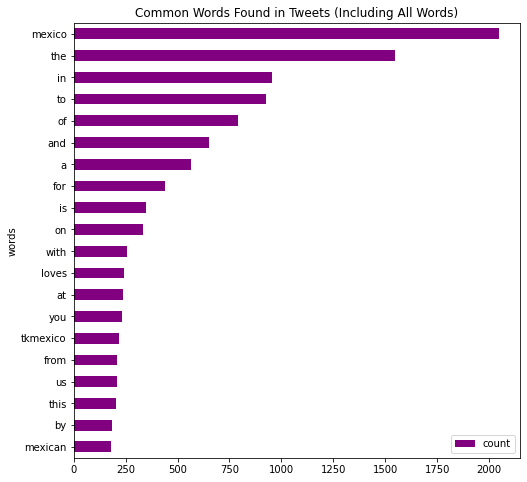

In [12]:
common_cs_top = plot_count(common_cs, "Common Words Found in Tweets (Including All Words)")

### Remove Stopwords

In [13]:
tweets_clean_str = remove_words(data['clean_str'])

In [14]:
tweets_cflatten = flatten_list(tweets_clean_str)

In [15]:
tweets_cfcount = count_common(tweets_cflatten)

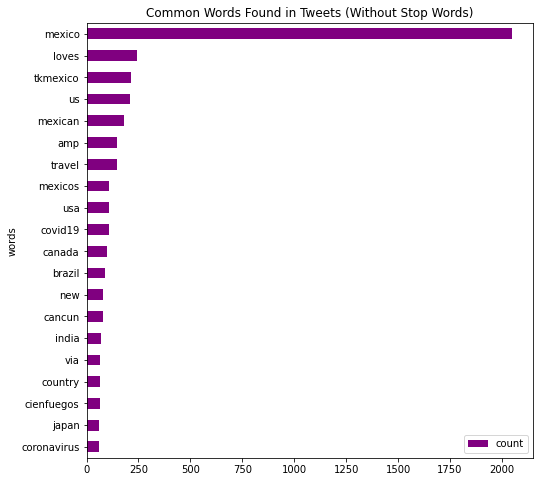

In [16]:
tweets_cfcplot = plot_count(tweets_cfcount, "Common Words Found in Tweets (Without Stop Words)")

### Remove collection words

In [17]:
collection_words = 'mexico'

In [18]:
tweets_corpus = remove_words(tweets_clean_str, collection_words)

In [19]:
tweets_corpus_flatten = flatten_list(tweets_corpus)

In [20]:
tweets_corpus_fcount = count_common(tweets_corpus_flatten)

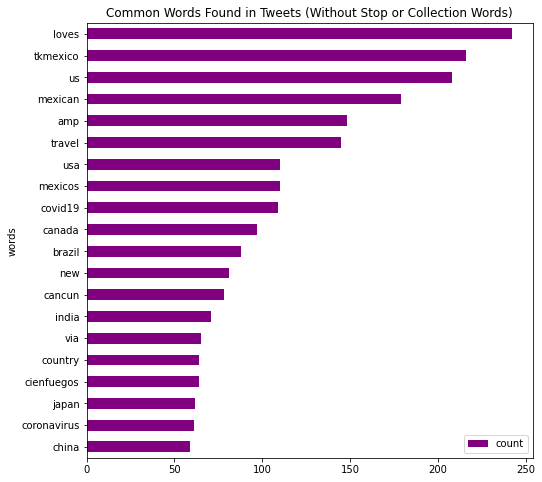

In [21]:
tweets_corpus_fcp = plot_count(tweets_corpus_fcount,"Common Words Found in Tweets (Without Stop or Collection Words)")

## Explore Co-occurring Words (Bigrams)

In [22]:
# tweets_corpus
# Create list of lists containing bigrams in tweets
def get_bigrams(tweets):
    """From a two level list returns a list of bigrams"""
    return [list(bigrams(tweet)) for tweet in tweets]

In [23]:
tweets_bigrams = get_bigrams(tweets_corpus)

In [24]:
tweets_bflatten = flatten_list(tweets_bigrams)

In [25]:
tweets_bfcount = count_common(tweets_bflatten)

In [26]:
tweets_bigramdf = pd.DataFrame(tweets_bfcount,
                             columns=['bigram', 'count'])

In [27]:
tweets_bigramdf

,bigram,count
0,"(loves, tkmexico)",216
1,"(tkmexico, loves)",216
2,"(loves, tk)",25
3,"(covid19, deaths)",21
4,"(united, states)",20
5,"(mexican, senate)",18
6,"(defense, minister)",18
7,"(brazil, india)",16
8,"(former, defense)",16
9,"(drug, trafficking)",15


In [28]:
# Create dictionary of bigrams and their counts
d = tweets_bigramdf.set_index('bigram').T.to_dict('records')


In [29]:
# Create network plot 
G = nx.Graph()

# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))

#G.add_node("mexico", weight=100)


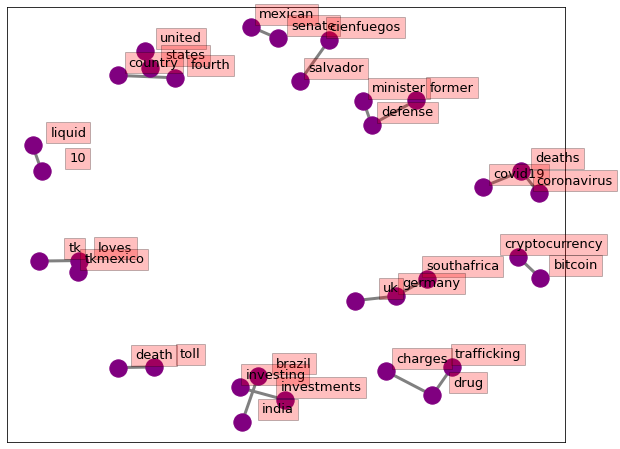

In [30]:
fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G, k=2)

# Plot networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=3,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# Create offset labels
for key, value in pos.items():
    x, y = value[0]+.135, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()


In [31]:
my_data = clean_str()

TypeError: clean_str() missing 1 required positional argument: 'df'

In [ ]:
data['full_text']

## Sentiment Analysis

In [ ]:
# Create textblob objects of the tweets

sentiment_objects = [TextBlob(tweet[0]) for tweet in data['clean_str']]

sentiment_objects[0].polarity, sentiment_objects[0]


In [ ]:
flaten_clean_str